无标记颜色 概率固定代码

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import numpy as np
import random

# 设置随机数种子
random.seed(42)
np.random.seed(42)

# 配置图表字体，防止中文乱码
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 零配件信息
components = {
    '零配件1': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件2': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件3': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件4': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件5': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件6': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件7': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件8': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
}

# 半成品信息
semi_products = {
    '半成品1': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品2': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品3': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
}

# 成品信息
final_product = {
    '成品': {'次品率': 0.1, '装配成本': 8, '检测成本': 6, '拆解费用': 10, '售价': 200, '调换损失': 40}
}

# 计算总成本（次品率不受检测影响）
def calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle):
    total_cost = 0

    # 计算零配件成本
    for i, (comp_name, comp_data) in enumerate(components.items()):
        cost = comp_data['购买单价']
        if detect_components[i]:
            cost += comp_data['检测成本']  # 增加检测成本
        total_cost += cost

    # 计算半成品成本
    for i, (semi_name, semi_data) in enumerate(semi_products.items()):
        cost = semi_data['装配成本']
        if detect_semi[i]:
            cost += semi_data['检测成本']  # 增加检测成本
        total_cost += cost

    # 计算成品成本
    final_cost = final_product['成品']['装配成本']
    if detect_final:
        final_cost += final_product['成品']['检测成本']  # 增加检测成本
    total_cost += final_cost

    # 换货损失，不受检测影响的成品次品率
    exchange_loss = final_product['成品']['调换损失'] * final_product['成品']['次品率']
    total_cost += exchange_loss

    # 拆解费用
    if dismantle:
        total_cost += final_product['成品']['拆解费用']

    return total_cost, final_product['成品']['次品率']

# 生成策略描述
def generate_strategy_description(detect_components, detect_semi, detect_final, dismantle):
    description = ""
    for i, detect in enumerate(detect_components):
        description += f"检测零配件 {i + 1}，" if detect else f"不检测零配件 {i + 1}，"
    for i, detect in enumerate(detect_semi):
        description += f"检测半成品 {i + 1}，" if detect else f"不检测半成品 {i + 1}，"
    if detect_final:
        description += "检测成品，"
    else:
        description += "不检测成品，"
    if dismantle:
        description += "拆解不合格成品"
    else:
        description += "不拆解不合格成品"
    return description

# 适应度函数
def fitness_function(chromosome, components, semi_products, final_product):
    detect_components = chromosome[:8]
    detect_semi = chromosome[8:11]
    detect_final = chromosome[11]
    dismantle = chromosome[12]

    cost, defective_rate = calculate_expected_cost(components, semi_products, final_product, detect_components,
                                                   detect_semi, detect_final, dismantle)
    return cost, defective_rate

# 初始化种群
def initialize_population(population_size, num_genes):
    return np.random.randint(2, size=(population_size, num_genes))

# 选择父代
def selection(population, fitness_values, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for i in range(num_parents):
        min_fitness_idx = np.argmin(fitness_values)
        parents[i, :] = population[min_fitness_idx, :]
        fitness_values[min_fitness_idx] = np.inf
    return parents

# 交叉
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# 变异
def mutation(offspring_crossover, mutation_rate):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_gene_idx = np.random.randint(offspring_crossover.shape[1])
            offspring_crossover[idx, random_gene_idx] = 1 - offspring_crossover[idx, random_gene_idx]
    return offspring_crossover

# 遗传算法主函数
def genetic_algorithm(components, semi_products, final_product, population_size=1000, num_generations=100, mutation_rate=0.01):
    num_genes = 13
    population = initialize_population(population_size, num_genes)
    results = []

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(chromosome, components, semi_products, final_product)[0] for chromosome in population])
        parents = selection(population, fitness_values, population_size // 2)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], num_genes))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        # 记录每一代的最优策略
        best_chromosome = population[np.argmin(fitness_values)]
        best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
        best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])
        results.append([generation + 1, best_strategy_description, best_cost, best_defective_rate])

    # 找到最优策略
    best_chromosome = population[np.argmin(fitness_values)]
    best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
    best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])

    return best_strategy_description, best_cost, best_defective_rate, results

# 使用遗传算法求解最优策略
best_strategy_description, best_cost, best_defective_rate, results = genetic_algorithm(components, semi_products, final_product)

# 打印最优策略
print("最优策略:", best_strategy_description)
print("总成本:", best_cost)
print("成品次品率:", best_defective_rate)

# 将结果转换为DataFrame并保存为Excel文件
df = pd.DataFrame(results, columns=["代数", "最优策略", "总成本", "成品次品率"])
df.to_excel('策略结果(不互相影响).xlsx', index=False)
print("所有策略已经保存到 '策略结果(不互相影响).xlsx' 文件中。")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(df['代数'], df['总成本'], marker='o', linestyle='-', color='blue', label="总成本")
plt.xlabel("代数")
plt.ylabel("总成本")
plt.title("不同策略下的总成本比较")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df['代数'], df['成品次品率'], marker='x', linestyle='--', color='red', label="成品次品率")
plt.xlabel("代数")
plt.ylabel("成品次品率")
plt.title("不同策略下的成品次品率比较")
plt.grid(True)
plt.legend()
plt.show()


有标记颜色 概率固定代码

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

# 设置字体及负号显示
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 零配件信息
components = {
    '零配件1': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件2': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件3': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件4': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件5': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件6': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件7': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件8': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
}

# 半成品信息
semi_products = {
    '半成品1': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品2': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品3': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
}

# 成品信息
final_product = {
    '成品': {'次品率': 0.1, '装配成本': 8, '检测成本': 6, '拆解费用': 10, '售价': 200, '调换损失': 40}
}

# 计算预期成本和次品率
def calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle):
    total_cost = 0
    total_defective_rate = 1

    for i, (comp_name, comp_data) in enumerate(components.items()):
        cost = comp_data['购买单价']
        defective_rate = comp_data['次品率']
        if detect_components[i]:
            defective_rate *= 0.5
            cost += comp_data['检测成本']

        total_cost += cost
        total_defective_rate *= (1 - defective_rate)

    for i, (semi_name, semi_data) in enumerate(semi_products.items()):
        cost = semi_data['装配成本']
        defective_rate = semi_data['次品率']
        if detect_semi[i]:
            defective_rate *= 0.5
            cost += semi_data['检测成本']

        total_cost += cost
        total_defective_rate *= (1 - defective_rate)

    final_defective_rate = final_product['成品']['次品率'] * (0.5 if detect_final else 1)
    final_cost = final_product['成品']['装配成本']

    if detect_final:
        final_cost += final_product['成品']['检测成本']

    total_cost += final_cost
    total_defective_rate = 1 - (total_defective_rate * (1 - final_defective_rate))

    exchange_loss = final_product['成品']['调换损失'] * total_defective_rate
    total_cost += exchange_loss

    if dismantle:
        total_cost += final_product['成品']['拆解费用']

    return total_cost, total_defective_rate

# 生成策略描述
def generate_strategy_description(detect_components, detect_semi, detect_final, dismantle):
    description = ""
    for i, detect in enumerate(detect_components):
        description += f"检测零配件 {i + 1}，" if detect else f"不检测零配件 {i + 1}，"
    for i, detect in enumerate(detect_semi):
        description += f"检测半成品 {i + 1}，" if detect else f"不检测半成品 {i + 1}，"
    if detect_final:
        description += "检测成品，"
    else:
        description += "不检测成品，"
    if dismantle:
        description += "拆解不合格成品"
    else:
        description += "不拆解不合格成品"
    return description

# 适应度函数
def fitness_function(chromosome, components, semi_products, final_product):
    detect_components = chromosome[:8]
    detect_semi = chromosome[8:11]
    detect_final = chromosome[11]
    dismantle = chromosome[12]

    cost, defective_rate = calculate_expected_cost(components, semi_products, final_product, detect_components,
                                                   detect_semi, detect_final, dismantle)
    return cost, defective_rate

# 初始化种群
def initialize_population(population_size, num_genes):
    return np.random.randint(2, size=(population_size, num_genes))

# 选择父代
def selection(population, fitness_values, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for i in range(num_parents):
        min_fitness_idx = np.argmin(fitness_values)
        parents[i, :] = population[min_fitness_idx, :]
        fitness_values[min_fitness_idx] = np.inf
    return parents

# 交叉操作
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# 变异操作
def mutation(offspring_crossover, mutation_rate):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_gene_idx = np.random.randint(offspring_crossover.shape[1])
            offspring_crossover[idx, random_gene_idx] = 1 - offspring_crossover[idx, random_gene_idx]
    return offspring_crossover

# 遗传算法主函数
def genetic_algorithm(components, semi_products, final_product, population_size=10000, num_generations=1000, mutation_rate=0.01):
    num_genes = 13
    population = initialize_population(population_size, num_genes)
    results = []

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(chromosome, components, semi_products, final_product)[0] for chromosome in population])
        parents = selection(population, fitness_values, population_size // 2)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], num_genes))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        # 记录每一代的最优策略
        best_chromosome = population[np.argmin(fitness_values)]
        best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
        best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])
        results.append([generation + 1, best_strategy_description, best_cost, best_defective_rate])

    # 找到最优策略
    best_chromosome = population[np.argmin(fitness_values)]
    best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
    best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])

    return best_strategy_description, best_cost, best_defective_rate, results

# 使用遗传算法求解最优策略
best_strategy_description, best_cost, best_defective_rate, results = genetic_algorithm(components, semi_products, final_product)

# 将结果保存到Excel文件中
df = pd.DataFrame(results, columns=['策略编号', '策略描述', '总成本', '成品次品率'])
df.to_excel('策略结果.xlsx', index=False)
print("所有策略已经保存到 '策略结果.xlsx' 文件中。")

print(f"最优策略: {best_strategy_description}")
print(f"最优策略总成本: {best_cost:.2f}")
print(f"最优策略成品次品率: {best_defective_rate:.2%}")

# 找到最低总成本和最低次品率的策略编号
min_cost_idx = df['总成本'].idxmin()
min_cost_strategy_num = df.loc[min_cost_idx, '策略编号']
min_cost_value = df.loc[min_cost_idx, '总成本']

min_defective_rate_idx = df['成品次品率'].idxmin()
min_defective_rate_strategy_num = df.loc[min_defective_rate_idx, '策略编号']
min_defective_rate_value = df.loc[min_defective_rate_idx, '成品次品率']

# 可视化总成本，并标出最低成本点
plt.figure(figsize=(10, 6))
plt.plot(df['策略编号'], df['总成本'], marker='o', linestyle='-', color='blue', label="总成本")
plt.scatter(min_cost_strategy_num, min_cost_value, color='red', label=f'最低成本（策略 {min_cost_strategy_num}）')
plt.text(min_cost_strategy_num, min_cost_value, f'最优策略 {min_cost_strategy_num}', color='red', fontsize=12, ha='right')
plt.xlabel("策略编号")
plt.ylabel("总成本")
plt.title("不同策略下的总成本比较")
plt.grid(True)
plt.legend()
plt.show()

# 可视化成品次品率，并标出最低次品率点
plt.figure(figsize=(10, 6))
plt.plot(df['策略编号'], df['成品次品率'], marker='x', linestyle='--', color='red', label="成品次品率")
plt.scatter(min_defective_rate_strategy_num, min_defective_rate_value, color='blue', label=f'最低次品率（策略 {min_defective_rate_strategy_num}）')
plt.text(min_defective_rate_strategy_num, min_defective_rate_value, f'最优策略 {min_defective_rate_strategy_num}', color='blue', fontsize=12, ha='right')
plt.xlabel("策略编号")
plt.ylabel("成品次品率")
plt.title("不同策略下的成品次品率比较")
plt.grid(True)
plt.legend()
plt.show()


加上其他示意图

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

components = {
    '零配件1': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件2': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件3': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件4': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件5': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件6': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件7': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件8': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
}

semi_products = {
    '半成品1': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品2': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品3': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
}

final_product = {
    '成品': {'次品率': 0.1, '装配成本': 8, '检测成本': 6, '拆解费用': 10, '售价': 200, '调换损失': 40}
}

def calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final,
                            dismantle):
    total_cost = 0
    total_defective_rate = 0

    for i, (comp_name, comp_data) in enumerate(components.items()):
        cost = comp_data['购买单价']
        defective_rate = comp_data['次品率']
        if detect_components[i]:
            defective_rate *= 0.5
            cost += comp_data['检测成本']

        total_cost += cost
        total_defective_rate += defective_rate

    for i, (semi_name, semi_data) in enumerate(semi_products.items()):
        cost = semi_data['装配成本']
        defective_rate = semi_data['次品率']
        if detect_semi[i]:
            defective_rate *= 0.5
            cost += semi_data['检测成本']

        total_cost += cost
        total_defective_rate += defective_rate

    final_defective_rate = final_product['成品']['次品率'] * (0.5 if detect_final else 1)
    final_cost = final_product['成品']['装配成本']

    if detect_final:
        final_cost += final_product['成品']['检测成本']

    total_cost += final_cost
    total_defective_rate += final_defective_rate

    exchange_loss = final_product['成品']['调换损失'] * total_defective_rate
    total_cost += exchange_loss

    if dismantle:
        total_cost += final_product['成品']['拆解费用']

    return total_cost, total_defective_rate

def generate_strategy_description(detect_components, detect_semi, detect_final, dismantle):
    description = ""
    for i, detect in enumerate(detect_components):
        description += f"检测零配件 {i + 1}，" if detect else f"不检测零配件 {i + 1}，"
    for i, detect in enumerate(detect_semi):
        description += f"检测半成品 {i + 1}，" if detect else f"不检测半成品 {i + 1}，"
    if detect_final:
        description += "检测成品，"
    else:
        description += "不检测成品，"
    if dismantle:
        description += "拆解不合格成品"
    else:
        description += "不拆解不合格成品"
    return description

def fitness_function(chromosome, components, semi_products, final_product):
    detect_components = chromosome[:8]
    detect_semi = chromosome[8:11]
    detect_final = chromosome[11]
    dismantle = chromosome[12]

    cost, defective_rate = calculate_expected_cost(components, semi_products, final_product, detect_components,
                                                   detect_semi, detect_final, dismantle)
    return cost, defective_rate

def initialize_population(population_size, num_genes):
    return np.random.randint(2, size=(population_size, num_genes))

def selection(population, fitness_values, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for i in range(num_parents):
        min_fitness_idx = np.argmin(fitness_values)
        parents[i, :] = population[min_fitness_idx, :]
        fitness_values[min_fitness_idx] = np.inf
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_gene_idx = np.random.randint(offspring_crossover.shape[1])
            offspring_crossover[idx, random_gene_idx] = 1 - offspring_crossover[idx, random_gene_idx]
    return offspring_crossover

def genetic_algorithm(components, semi_products, final_product, population_size=10000, num_generations=100, mutation_rate=0.01):
    num_genes = 13
    population = initialize_population(population_size, num_genes)
    results = []

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(chromosome, components, semi_products, final_product)[0] for chromosome in population])
        parents = selection(population, fitness_values, population_size // 2)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], num_genes))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        # 记录每一代的最优策略
        best_chromosome = population[np.argmin(fitness_values)]
        best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
        best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])
        results.append([generation + 1, best_strategy_description, best_cost, best_defective_rate])

    # 找到最优策略
    best_chromosome = population[np.argmin(fitness_values)]
    best_cost, best_defective_rate = fitness_function(best_chromosome, components, semi_products, final_product)
    best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])

    return best_strategy_description, best_cost, best_defective_rate, results

# 使用遗传算法求解最优策略
best_strategy_description, best_cost, best_defective_rate, results = genetic_algorithm(components, semi_products, final_product)

# 将结果保存到Excel文件中
df = pd.DataFrame(results, columns=['策略编号', '策略描述', '总成本', '成品次品率'])
df.to_excel('策略结果.xlsx', index=False)
print("所有策略已经保存到 '策略结果.xlsx' 文件中。")

print(f"最优策略: {best_strategy_description}")
print(f"最优策略总成本: {best_cost:.2f}")
print(f"最优策略成品次品率: {best_defective_rate:.2f}")

# 可视化结果
plt.figure(figsize=(14, 10))

# 总成本
plt.subplot(2, 1, 1)
plt.plot(df['策略编号'], df['总成本'], marker='o', linestyle='-', color='blue', label="总成本")
plt.xlabel("策略编号")
plt.ylabel("总成本")
plt.title("不同策略下的总成本比较")
plt.grid(True)
plt.legend()

# 成品次品率
plt.subplot(2, 1, 2)
plt.plot(df['策略编号'], df['成品次品率'], marker='x', linestyle='--', color='red', label="成品次品率")
plt.xlabel("策略编号")
plt.ylabel("成品次品率")
plt.title("不同策略下的成品次品率比较")
plt.grid(True)
plt.legend()

# 显示最小值、最大值、平均值和标准差
plt.figure(figsize=(14, 10))

# 总成本
plt.subplot(2, 1, 1)
plt.plot(df['策略编号'], df['总成本'], marker='o', linestyle='-', color='blue', label="总成本")
plt.fill_between(df['策略编号'], df['总成本'].min(), df['总成本'].max(), color='lightblue', alpha=0.5, label="最小值-最大值范围")
plt.plot(df['策略编号'], df['总成本'].rolling(window=5).mean(), linestyle='--', color='green', label="5代平均值")
plt.xlabel("策略编号")
plt.ylabel("总成本")
plt.title("不同策略下的总成本比较")
plt.grid(True)
plt.legend()

# 成品次品率
plt.subplot(2, 1, 2)
plt.plot(df['策略编号'], df['成品次品率'], marker='x', linestyle='--', color='red', label="成品次品率")
plt.fill_between(df['策略编号'], df['成品次品率'].min(), df['成品次品率'].max(), color='lightcoral', alpha=0.5, label="最小值-最大值范围")
plt.plot(df['策略编号'], df['成品次品率'].rolling(window=5).mean(), linestyle='--', color='green', label="5代平均值")
plt.xlabel("策略编号")
plt.ylabel("成品次品率")
plt.title("不同策略下的成品次品率比较")
plt.grid(True)
plt.legend()

# 显示箱线图
plt.figure(figsize=(14, 10))

# 总成本
plt.subplot(2, 1, 1)
plt.boxplot(df['总成本'], vert=False)
plt.xlabel("总成本")
plt.title("总成本分布")
plt.grid(True)

# 成品次品率
plt.subplot(2, 1, 2)
plt.boxplot(df['成品次品率'], vert=False)
plt.xlabel("成品次品率")
plt.title("成品次品率分布")
plt.grid(True)

plt.show()

固定概率

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

components = {
    '零配件1': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件2': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件3': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件4': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件5': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件6': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件7': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件8': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
}

semi_products = {
    '半成品1': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品2': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品3': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
}

final_product = {
    '成品': {'次品率': 0.1, '装配成本': 8, '检测成本': 6, '拆解费用': 10, '售价': 200, '调换损失': 40}
}

def calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle):
    total_cost = 0

    for i, (comp_name, comp_data) in enumerate(components.items()):
        cost = comp_data['购买单价']
        if detect_components[i]:
            cost += comp_data['检测成本']
        total_cost += cost

    for i, (semi_name, semi_data) in enumerate(semi_products.items()):
        cost = semi_data['装配成本']
        if detect_semi[i]:
            cost += semi_data['检测成本']
        total_cost += cost

    final_cost = final_product['成品']['装配成本']
    if detect_final:
        final_cost += final_product['成品']['检测成本']
    total_cost += final_cost

    exchange_loss = final_product['成品']['调换损失'] * 0.1
    total_cost += exchange_loss

    if dismantle:
        total_cost += final_product['成品']['拆解费用']

    return total_cost

def generate_strategy_description(detect_components, detect_semi, detect_final, dismantle):
    description = ""
    for i, detect in enumerate(detect_components):
        description += f"检测零配件 {i + 1}，" if detect else f"不检测零配件 {i + 1}，"
    for i, detect in enumerate(detect_semi):
        description += f"检测半成品 {i + 1}，" if detect else f"不检测半成品 {i + 1}，"
    if detect_final:
        description += "检测成品，"
    else:
        description += "不检测成品，"
    if dismantle:
        description += "拆解不合格成品"
    else:
        description += "不拆解不合格成品"
    return description

def fitness_function(chromosome, components, semi_products, final_product):
    detect_components = chromosome[:8]
    detect_semi = chromosome[8:11]
    detect_final = chromosome[11]
    dismantle = chromosome[12]

    cost = calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle)
    return cost

def initialize_population(population_size, num_genes):
    return np.random.randint(2, size=(population_size, num_genes))

def selection(population, fitness_values, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for i in range(num_parents):
        min_fitness_idx = np.argmin(fitness_values)
        parents[i, :] = population[min_fitness_idx, :]
        fitness_values[min_fitness_idx] = np.inf
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_gene_idx = np.random.randint(offspring_crossover.shape[1])
            offspring_crossover[idx, random_gene_idx] = 1 - offspring_crossover[idx, random_gene_idx]
    return offspring_crossover

def genetic_algorithm(components, semi_products, final_product, population_size=1000, num_generations=1000, mutation_rate=0.01):
    num_genes = 13
    population = initialize_population(population_size, num_genes)
    results = []

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(chromosome, components, semi_products, final_product) for chromosome in population])
        parents = selection(population, fitness_values, population_size // 2)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], num_genes))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        # 记录每一代的最优策略
        best_chromosome = population[np.argmin(fitness_values)]
        best_cost = fitness_function(best_chromosome, components, semi_products, final_product)
        best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])
        results.append([generation + 1, best_strategy_description, best_cost])

    # 找到最优策略
    best_chromosome = population[np.argmin(fitness_values)]
    best_cost = fitness_function(best_chromosome, components, semi_products, final_product)
    best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12])

    return best_strategy_description, best_cost, results

# 使用遗传算法求解最优策略
best_strategy_description, best_cost, results = genetic_algorithm(components, semi_products, final_product)

# 将结果保存到Excel文件中
df = pd.DataFrame(results, columns=['策略编号', '策略描述', '总成本'])
df.to_excel('策略结果.xlsx', index=False)
print("所有策略已经保存到 '策略结果.xlsx' 文件中。")

print(f"最优策略: {best_strategy_description}")
print(f"最优策略总成本: {best_cost:.2f}")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(df['策略编号'], df['总成本'], marker='o', linestyle='-', color='blue', label="总成本")
plt.xlabel("策略编号")
plt.ylabel("总成本")
plt.title("不同策略下的总成本比较")
plt.grid(True)
plt.legend()
plt.show()


最新固定概率

所有策略已经保存到 '策略结果.xlsx' 文件中。
最优策略: 不检测零配件 1，不检测零配件 2，不检测零配件 3，不检测零配件 4，不检测零配件 5，不检测零配件 6，不检测零配件 7，不检测零配件 8，不检测半成品 1，不检测半成品 2，不检测半成品 3，不检测成品，不拆解半成品 1，不拆解半成品 2，不拆解半成品 3，不拆解不合格成品
最优策略总成本: 100.00


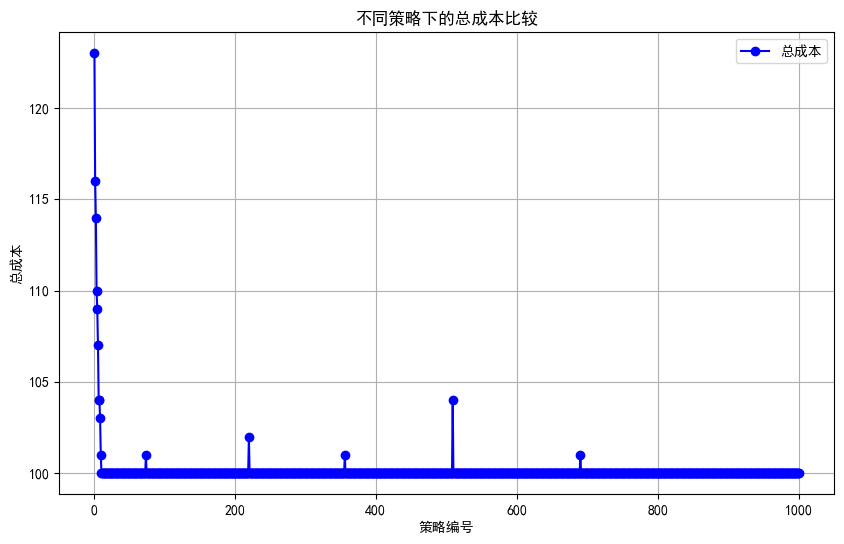

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

components = {
    '零配件1': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件2': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件3': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件4': {'次品率': 0.1, '购买单价': 2, '检测成本': 1},
    '零配件5': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件6': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
    '零配件7': {'次品率': 0.1, '购买单价': 8, '检测成本': 1},
    '零配件8': {'次品率': 0.1, '购买单价': 12, '检测成本': 2},
}

semi_products = {
    '半成品1': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品2': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
    '半成品3': {'次品率': 0.1, '装配成本': 8, '检测成本': 4, '拆解费用': 6},
}

final_product = {
    '成品': {'次品率': 0.1, '装配成本': 8, '检测成本': 6, '拆解费用': 10, '售价': 200, '调换损失': 40}
}

def calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle_semi, dismantle_final):
    total_cost = 0

    for i, (comp_name, comp_data) in enumerate(components.items()):
        cost = comp_data['购买单价']
        if detect_components[i]:
            cost += comp_data['检测成本']
        total_cost += cost

    total_defective_rate = 1
    for i, (semi_name, semi_data) in enumerate(semi_products.items()):
        cost = semi_data['装配成本']
        if detect_semi[i]:
            cost += semi_data['检测成本']
        total_cost += cost

        if dismantle_semi[i]:
            total_cost += semi_data['拆解费用']
            
    final_cost = final_product['成品']['装配成本']
    if detect_final:
        final_cost += final_product['成品']['检测成本']
    total_cost += final_cost

    exchange_loss = final_product['成品']['调换损失'] * 0.1
    total_cost += exchange_loss

    if dismantle_final:
        total_cost += final_product['成品']['拆解费用']

    return total_cost

def generate_strategy_description(detect_components, detect_semi, detect_final, dismantle_semi, dismantle_final):
    description = ""
    for i, detect in enumerate(detect_components):
        description += f"检测零配件 {i + 1}，" if detect else f"不检测零配件 {i + 1}，"
    for i, detect in enumerate(detect_semi):
        description += f"检测半成品 {i + 1}，" if detect else f"不检测半成品 {i + 1}，"
    if detect_final:
        description += "检测成品，"
    else:
        description += "不检测成品，"
    for i, dismantle in enumerate(dismantle_semi):
        description += f"拆解半成品 {i + 1}，" if dismantle else f"不拆解半成品 {i + 1}，"
    if dismantle_final:
        description += "拆解不合格成品"
    else:
        description += "不拆解不合格成品"
    return description

def fitness_function(chromosome, components, semi_products, final_product):
    detect_components = chromosome[:8]
    detect_semi = chromosome[8:11]
    detect_final = chromosome[11]
    dismantle_semi = chromosome[12:15]
    dismantle_final = chromosome[15]

    cost = calculate_expected_cost(components, semi_products, final_product, detect_components, detect_semi, detect_final, dismantle_semi, dismantle_final)
    return cost

def initialize_population(population_size, num_genes):
    return np.random.randint(2, size=(population_size, num_genes))

def selection(population, fitness_values, num_parents):
    parents = np.empty((num_parents, population.shape[1]), dtype=int)
    for i in range(num_parents):
        min_fitness_idx = np.argmin(fitness_values)
        parents[i, :] = population[min_fitness_idx, :]
        fitness_values[min_fitness_idx] = np.inf
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size, dtype=int)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_gene_idx = np.random.randint(offspring_crossover.shape[1])
            offspring_crossover[idx, random_gene_idx] = 1 - offspring_crossover[idx, random_gene_idx]
    return offspring_crossover

def genetic_algorithm(components, semi_products, final_product, population_size=1000, num_generations=1000, mutation_rate=0.01):
    num_genes = 16  # 更新为16个基因（8个零配件检测、3个半成品检测、1个成品检测、3个半成品拆解、1个成品拆解）
    population = initialize_population(population_size, num_genes)
    results = []

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(chromosome, components, semi_products, final_product) for chromosome in population])
        parents = selection(population, fitness_values, population_size // 2)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], num_genes))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        # 记录每一代的最优策略
        best_chromosome = population[np.argmin(fitness_values)]
        best_cost = fitness_function(best_chromosome, components, semi_products, final_product)
        best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12:15], best_chromosome[15])
        results.append([generation + 1, best_strategy_description, best_cost])

    # 找到最优策略
    best_chromosome = population[np.argmin(fitness_values)]
    best_cost = fitness_function(best_chromosome, components, semi_products, final_product)
    best_strategy_description = generate_strategy_description(best_chromosome[:8], best_chromosome[8:11], best_chromosome[11], best_chromosome[12:15], best_chromosome[15])

    return best_strategy_description, best_cost, results

# 使用遗传算法求解最优策略
best_strategy_description, best_cost, results = genetic_algorithm(components, semi_products, final_product)

# 将结果保存到Excel文件中
df = pd.DataFrame(results, columns=['策略编号', '策略描述', '总成本'])
df.to_excel('B3策略结果.xlsx', index=False)
print("所有策略已经保存到 'B3策略结果.xlsx' 文件中。")

print(f"最优策略: {best_strategy_description}")
print(f"最优策略总成本: {best_cost:.2f}")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(df['策略编号'], df['总成本'], marker='o', linestyle='-', color='blue', label="总成本")
plt.xlabel("策略编号")
plt.ylabel("总成本")
plt.title("不同策略下的总成本比较")
plt.grid(True)
plt.legend()
plt.show()
